In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## aisles.csv

*aisles* is a small reference dataset containing the aisle id and description.

In [60]:
ais = pd.read_csv('./data/aisles.csv')
ais.shape

(134, 2)

In [61]:
ais.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


## departments.csv

*departments* is a small reference dataset containing the department id and description.

In [9]:
dpts = pd.read_csv('./data/departments.csv')
dpts.shape

(21, 2)

In [10]:
dpts.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [11]:
dpts['department'].unique()

array(['frozen', 'other', 'bakery', 'produce', 'alcohol', 'international',
       'beverages', 'pets', 'dry goods pasta', 'bulk', 'personal care',
       'meat seafood', 'pantry', 'breakfast', 'canned goods', 'dairy eggs',
       'household', 'babies', 'snacks', 'deli', 'missing'], dtype=object)

## products.csv

*products* is a ~50k record dataset of all the different products sold on the website. The *products* dataset contains the aisle and department id, so we want to merge the values from those datasets into *products*.

In [17]:
prod_basic = pd.read_csv('./data/products.csv')
prod_basic.shape

(49688, 4)

In [19]:
prod_basic.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


Merge the *aisle* and *department* information into the *products* dataset.

In [62]:
prod_full = pd.merge(prod_basic, ais, how='left', left_on='aisle_id', right_on='aisle_id')
prod_full = pd.merge(prod_full, dpts, \
                            how='left', left_on='department_id', right_on='department_id')
prod_full.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


We might also want to understand the number of products in each aisle. Interstingly we find the the largest grouping for aisle is actually *missing values*, so we may need to account for this in our model.

In [63]:
prod_grp = prod_full['product_name'].groupby(prod_full['aisle']).count()
prod_grp.sort_values(ascending=False).head()

aisle
missing                 1258
candy chocolate         1246
ice cream ice           1091
vitamins supplements    1038
yogurt                  1026
Name: product_name, dtype: int64

We can also look at the number of aisles in each department.

In [64]:
# Group the full dataframe by department & aisle.
ais_grp = prod_full.groupby(['department','aisle']).size().reset_index().rename(columns={0:'count'})
# Group the grouped dataframe by department to get aisle count.
dep_grp = ais_grp['aisle'].groupby(ais_grp['department']).count()
dep_grp

department
alcohol             5
babies              4
bakery              5
beverages           8
breakfast           4
bulk                2
canned goods        5
dairy eggs         10
deli                5
dry goods pasta     5
frozen             11
household          10
international       4
meat seafood        7
missing             1
other               1
pantry             12
personal care      17
pets                2
produce             5
snacks             11
Name: aisle, dtype: int64

## order_products__prior.csv

*order_products__prior* is a large dataset containing previous order history, with the order id, product id, order in which it was added to the cart, and whether the item was a reorder or not (which is our target variable).

In [69]:
opp = pd.read_csv('./data/order_products__prior.csv')
opp.shape

(32434489, 4)

In [70]:
opp.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


Add in the product, department, and aisle names.

In [71]:
opp_full = pd.merge(opp, prod_full, how='left', left_on='product_id', right_on='product_id')
opp_full.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


We can demonstrate that *add_to_cart_order* just gives the numbering of the order in which products were added to each order, and therefore may be of no predictive value for this problem.

In [73]:
# Add a column to count the number of products in each order.
opp_full['product_count'] = opp_full.groupby('order_id')['order_id'].transform('count')

# Now add a column to find the maximum 'add_to_cart_order' order for each order.
opp_full['add_to_cart_max'] = opp_full.groupby('order_id')['add_to_cart_order'].transform('max')

# If our assumption is correct then the values in the 2 new columns should always match.
# Add a column to check if these values match.
opp_full['match'] = np.where(opp_full['product_count']==opp_full['add_to_cart_max'],
                                          True, False)
opp_full.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,product_count,add_to_cart_max,match
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,9,9,True
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,9,9,True
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,9,9,True
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,9,9,True
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,9,9,True
5,2,17794,6,1,Carrots,83,4,fresh vegetables,produce,9,9,True
6,2,40141,7,1,Original Unflavored Gelatine Mix,105,13,doughs gelatins bake mixes,pantry,9,9,True
7,2,1819,8,1,All Natural No Stir Creamy Almond Butter,88,13,spreads,pantry,9,9,True
8,2,43668,9,0,Classic Blend Cole Slaw,123,4,packaged vegetables fruits,produce,9,9,True
9,3,33754,1,1,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs,8,8,True


In [74]:
# Now check to see if all match values are True.
opp_full['match'].unique()

array([True], dtype=object)

##### Confirmed!
*add_to_cart_order* is just a count of the items in each order, so is not required for this analysis.

We can now use the *product_count* feature we just created look at the distribution of number of products per order. We see that most orders contain below 20 products.

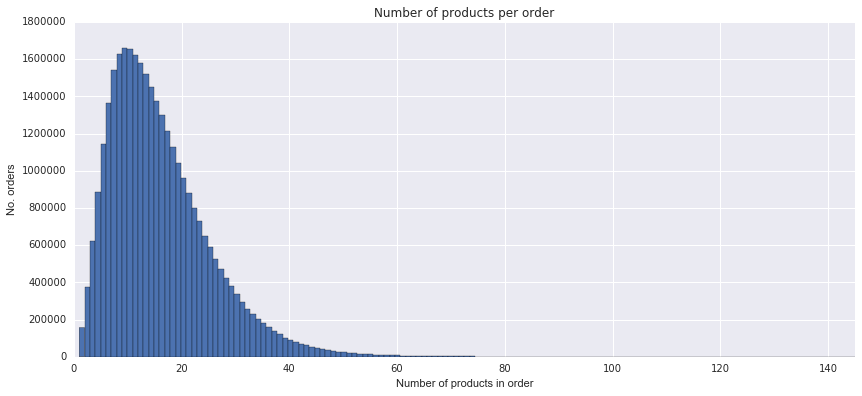

In [186]:
number_bins = opp_full['product_count'].max()
plt.figure(num=1,figsize=(14,6))
plt.hist(opp_full['product_count'], bins=number_bins)
plt.xlabel('Number of products in order')
plt.ylabel('No. orders')
plt.title('Number of products per order')
plt.ticklabel_format(style='plain')
plt.xlim(0,number_bins)
plt.show()

And for each product we can calculate its propensity to be reorded, as the sum of the *reordered* column for each product (because the reorder values are either 0 or 1), divided by the total number of times the product was ordered.

In [91]:
# Groupby to calculate the number of times each product_id appears in the df
numberBought = opp_full['product_id'].groupby(opp_full['product_id']).count()

# Groupby to sum the values in the reorded column for each product_id (since 1 = True) 
reorders = opp_full['reordered'].groupby(opp_full['product_id']).sum()

# Combine into 1 dataframe
product_df = pd.concat([numberBought, reorders], axis=1)

# Calculate reorder_rate as the reorder total divided by total number of orders
product_df['reorder_rate'] = product_df['reordered'] / product_df['product_id']

# Rename columns
product_df.rename(columns={'product_id':'number_bought'}, inplace=True)

# Sort by reorder rate then by number of orders, highest to lowest
product_df.sort_values(by=['reorder_rate','number_bought'], axis=0, ascending=False, inplace=True)

# Make product_id into a column
product_df.reset_index(level=0, inplace=True)

# Merge in product name info.
product_df = pd.merge(product_df, prod_full[['product_id','aisle','department','product_name']], \
                      how='left', left_on='product_id', right_on='product_id')

product_df.head()

,product_id,number_bought,reordered,reorder_rate,aisle,department,product_name
0,6433,68,64,0.941176,prepared meals,deli,Raw Veggie Wrappers
1,2075,87,81,0.931034,feminine care,personal care,Serenity Ultimate Extrema Overnight Pads
2,43553,13,12,0.923077,energy sports drinks,beverages,Orange Energy Shots
3,27740,101,93,0.920792,candy chocolate,snacks,Chocolate Love Bar
4,14609,35,32,0.914286,baby food formula,babies,Soy Powder Infant Formula


In [92]:
product_df.tail()

,product_id,number_bought,reordered,reorder_rate,aisle,department,product_name
49672,48151,1,0,0.0,missing,missing,Grill Mates Brown Sugar Bourbon Seasoning
49673,48211,1,0,0.0,instant foods,dry goods pasta,Cajun Sides Dirty Rice
49674,48343,1,0,0.0,beers coolers,alcohol,Hennepin Farmhouse Ale
49675,48461,1,0,0.0,ice cream toppings,snacks,The Ultimate Caramel Suace
49676,49487,1,0,0.0,dog food care,pets,Vitality Chicken Breasts with Flaxseed & Vitam...


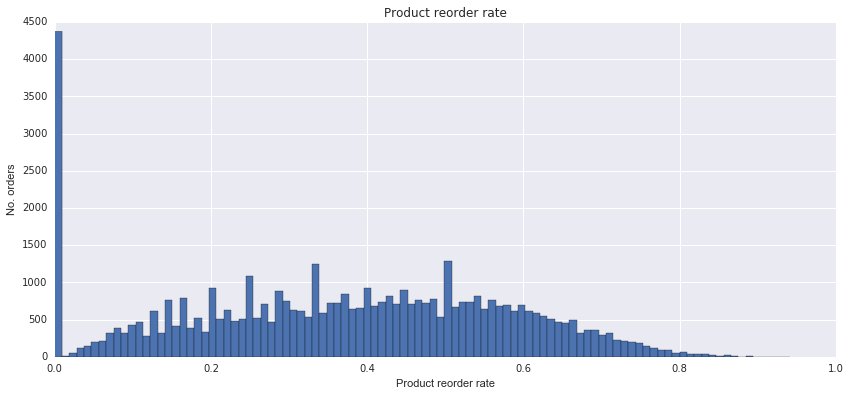

In [187]:
# Plot the reorded rate as a histogram
plt.figure(num=2,figsize=(14,6))
plt.hist(product_df['reorder_rate'],bins=100)
plt.xlabel('Product reorder rate')
plt.ylabel('No. orders')
plt.title('Product reorder rate')
plt.ticklabel_format(style='plain')
plt.xlim(0,1)
plt.show()

Products have sold an average of 653 times:

In [114]:
product_df['number_bought'].mean()

652.90756285605

The most poular product is bananas, selling 473k times:

In [116]:
product_df[product_df['number_bought']==product_df['number_bought'].max()]

,product_id,number_bought,reordered,reorder_rate,aisle,department,product_name
72,24852,472565,398609,0.843501,fresh fruits,produce,Banana


131 different products have only sold once:

In [109]:
product_df[product_df['number_bought']==1]['number_bought'].count()

131

Let's see if there is an obvious correlation between how well a product sells and how often it is reordered, which seems like a logical assumption. We'll also colour code the data points by *department*, to see if any obvious patterns emerge.

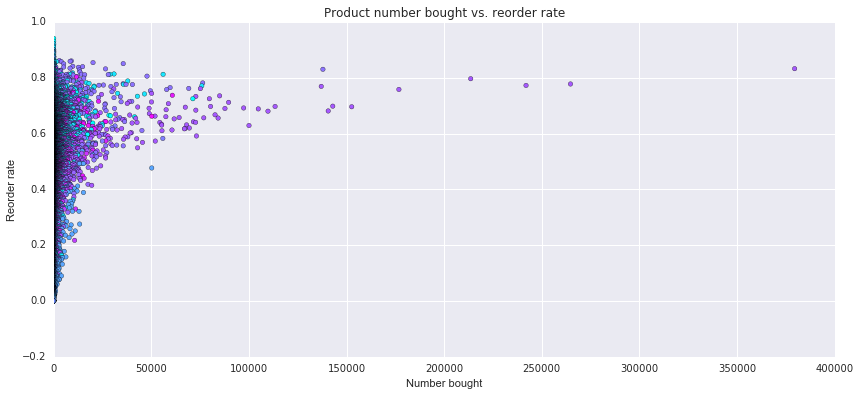

In [182]:
# Create colour field in dataframe with integers representing each department.

# Create colour mapping
depts = product_df['department'].unique()
colours = {}
for dept in range(len(depts)):
    colours[depts[dept]]=dept

# Apply colour mapping to dataframe
for row in range(len(product_df)):
    product_df.loc[row, 'colour']=colours[product_df.loc[row, 'department']]

# Plot the number sold against the reorder rate, as a scatter plot.
plt.figure(num=3,figsize=(14,6))
plt.scatter(x=product_df['number_bought'], y=product_df['reorder_rate'], c=product_df['colour'], cmap=plt.cm.cool)
plt.xlabel('Number bought')
plt.ylabel('Reorder rate')
plt.title('Product number bought vs. reorder rate')
plt.ticklabel_format(style='plain')
plt.xlim(0,400000)
plt.show()

Let's shorten the x-axis to get a better picture, by excluding the high-selling outliers. Knowing that products sell an average of 653 times, we'll limit the x-axis to 1000.

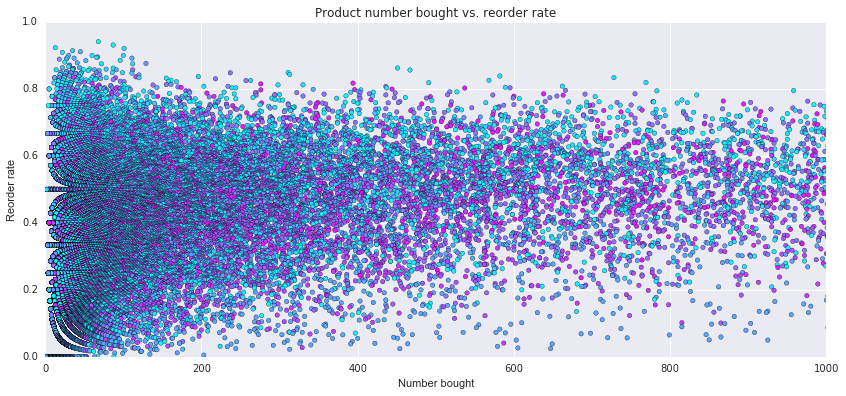

In [183]:
# Create the scatter plot
plt.figure(num=4,figsize=(14,6))
plt.scatter(x=product_df['number_bought'], y=product_df['reorder_rate'], c=product_df['colour'], cmap=plt.cm.cool)
plt.xlabel('Number bought')
plt.ylabel('Reorder rate')
plt.title('Product number bought vs. reorder rate')
plt.ticklabel_format(style='plain')
plt.xlim(0,1000) # Limiting x-axis to 1000 now
plt.ylim(0,1)
plt.show()

In [184]:
print len(opp_full['order_id'].unique()), 'unique orders.'

3214874 unique orders.


In [185]:
print 'Average',round(float(len(opp_full)) / len(opp_full['order_id'].unique()),2) , 'products per order.'

Average 10.09 products per order.


## order_products__train.csv

In [42]:
order_products__train = pd.read_csv('./data/order_products__train.csv')
order_products__train.head(2)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1


In [43]:
order_products__train.shape

(1384617, 4)

## orders.csv

In [44]:
orders = pd.read_csv('./data/orders.csv')
orders.shape

(3421083, 7)

In [45]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [16]:
orders['order_number'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

What does the *order_number* feature signify? Why only 100 different values?

In [32]:
orders['eval_set'].unique()

array(['prior', 'train', 'test'], dtype=object)

In [35]:
orders['user_id'].unique()

array([     1,      2,      3, ..., 206207, 206208, 206209])

See how many unique users are in each dataset.

In [38]:
for order_set in orders['eval_set'].unique():
    print order_set, len(orders[orders['eval_set']==order_set]['user_id'].unique())

 prior 206209
train 131209
test 75000


## sample_submission.csv

In [24]:
sample_submission = pd.read_csv('../data/sample_submission.csv')
sample_submission.head(2)

,order_id,products
0,17,39276 29259
1,34,39276 29259
